# Heart Disease Predictor

## Enunciado del Problema
El problema que abordaremos es el desarrollo de un modelo predictivo capaz de determinar el riesgo de enfermedades cardiovasculares en individuos. Utilizaremos variables como la edad, género, presión arterial, y otras medidas clínicas para predecir si un individuo tiene un alto riesgo de desarrollar este tipo de enfermedades.

## Objetivos del Proyecto
Realizar un análisis exploratorio completo de los datos para entender las distribuciones, correlaciones y posibles anomalías en las variables.
Preparar los datos para el modelado mediante la limpieza, normalización y codificación de las variables necesarias.
Seleccionar la métrica de evaluación adecuada para medir la efectividad de los modelos de machine learning, considerando la precisión, sensibilidad, especificidad y el área bajo la curva ROC como posibles candidatos.
Comparar diferentes modelos de machine learning para identificar el más adecuado en términos de precisión y robustez. Experimentaremos con al menos tres modelos diferentes: regresión logística, random forest y XGBoost.
Comunicar efectivamente los resultados obtenidos a través de visualizaciones y un informe detallado que documente todo el proceso y las conclusiones.

In [2]:
# Standard libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Scikit-learn components for data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.linear_model import *
# Scikit-learn components for modeling and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier



# Imbalanced-learn pipeline and resampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks

# XGBoost classifier
from xgboost import XGBClassifier


## Análisis Exploratorio de Datos (EDA)
Vamos a cargar el dataset y empezar con el EDA, explorando las primeras filas del dataset, estadísticas descriptivas y visualizaciones de las distribuciones de las variables.

In [3]:
# Cargar los datos
data = pd.read_csv("./datos/CVD_cleaned.csv")

# Mostrar las primeras filas del dataset
print(data.head().T)




                                                    0                     1  \
General_Health                                   Poor             Very Good   
Checkup                       Within the past 2 years  Within the past year   
Exercise                                           No                    No   
Heart_Disease                                      No                   Yes   
Skin_Cancer                                        No                    No   
Other_Cancer                                       No                    No   
Depression                                         No                    No   
Diabetes                                           No                   Yes   
Arthritis                                         Yes                    No   
Sex                                            Female                Female   
Age_Category                                    70-74                 70-74   
Height_(cm)                                     150.

In [19]:
# Estadísticas descriptivas
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Height_(cm),308854.0,170.615249,10.658026,91.00,163.00,170.00,178.00,241.00
Weight_(kg),308854.0,83.588655,21.343210,24.95,68.04,81.65,95.25,293.02
BMI,308854.0,28.626211,6.522323,12.02,24.21,27.44,31.85,99.33
Alcohol_Consumption,308854.0,5.096366,8.199763,0.00,0.00,1.00,6.00,30.00
Fruit_Consumption,308854.0,29.835200,24.875735,0.00,12.00,30.00,30.00,120.00
Green_Vegetables_Consumption,308854.0,15.110441,14.926238,0.00,4.00,12.00,20.00,128.00
FriedPotato_Consumption,308854.0,6.296616,8.582954,0.00,2.00,4.00,8.00,128.00


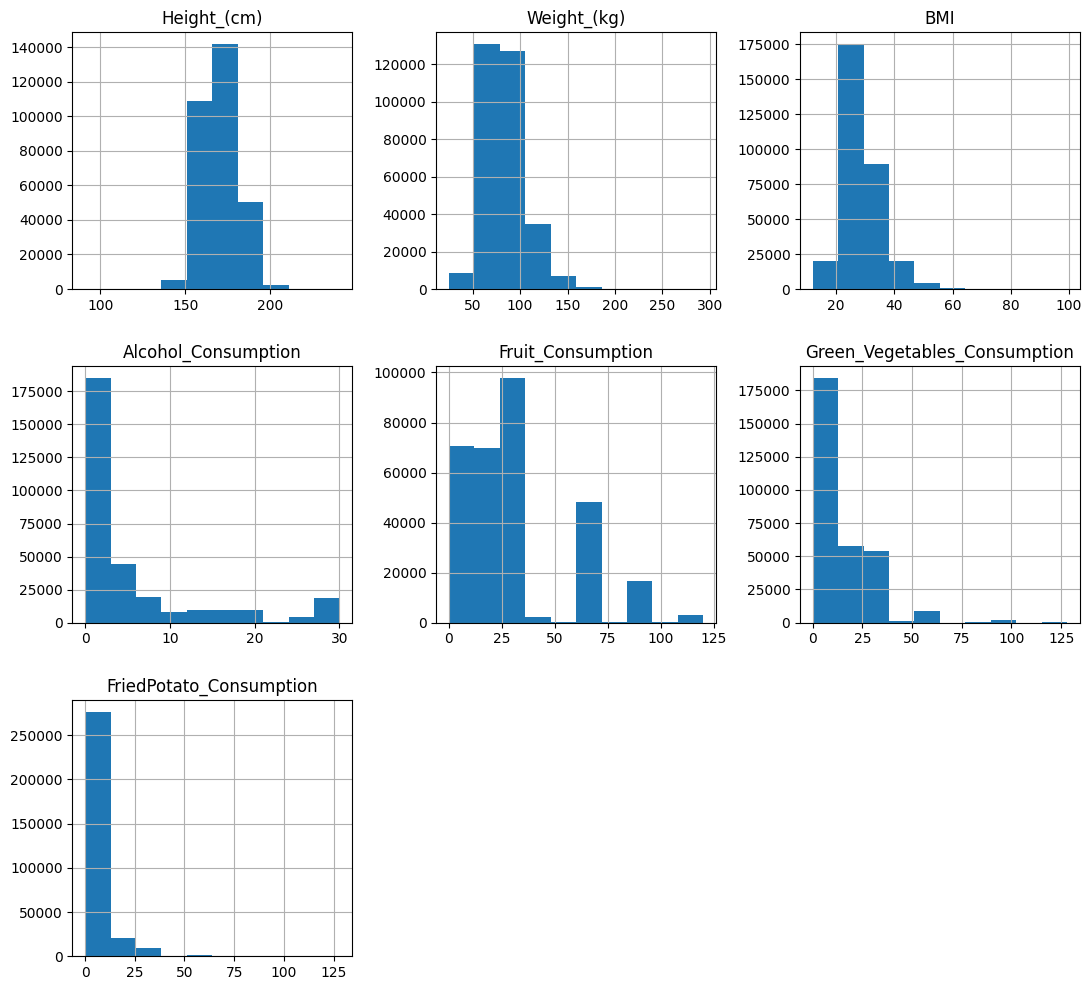

In [4]:
data.hist(figsize=(13,12));

1. Height (cm): La distribución de la altura parece ser aproximadamente normal, con la mayoría de los individuos agrupados alrededor de una altura que podría estar en el rango de 150 a 175 cm. Hay pocos individuos con alturas extremadamente bajas o altas.

2. Weight (kg): La distribución del peso muestra una tendencia similar a la de la altura, con un pico que sugiere que la mayoría de los individuos tienen un peso que podría estar alrededor de 50 a 100 kg. La cola hacia la derecha indica que hay menos individuos con pesos más altos.

3. BMI (Body Mass Index): El Índice de Masa Corporal también muestra una distribución con un pico prominente, probablemente en el rango de 20 a 30, lo que indica un rango de peso normal a sobrepeso para la mayoría de los individuos. La distribución tiene una cola larga hacia la derecha, indicando la presencia de individuos con valores de BMI más altos, posiblemente obesos.

4. Alcohol_Consumption: Esta variable parece estar sesgada a la derecha, con la mayoría de los individuos consumiendo poco o ningún alcohol, y muy pocos individuos consumiendo grandes cantidades.

5. Fruit_Consumption: El consumo de frutas varía más que el consumo de alcohol, con picos en valores bajos y luego en un rango que podría ser alrededor de 100 unidades (la unidad no está definida en el eje x). Esto podría indicar que algunos individuos consumen frutas con mucha frecuencia o en grandes cantidades.

6. Green_Vegetables_Consumption: El consumo de vegetales verdes tiene un patrón similar al consumo de frutas, con un pico en un valor bajo y otro pico alrededor de 100 unidades. Esto sugiere dos grupos de individuos: aquellos que consumen pocas verduras verdes y aquellos que consumen una cantidad considerablemente mayor.

7. FriedPotato_Consumption: La mayoría de los individuos consume una cantidad muy baja de papas fritas, con un pico muy alto cerca del valor más bajo. Es probable que la frecuencia del consumo de papas fritas sea generalmente baja entre la población del dataset.

General_Health
Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: count, dtype: int64
Sex
Female    160196
Male      148658
Name: count, dtype: int64
Heart_Disease
No     283883
Yes     24971
Name: count, dtype: int64


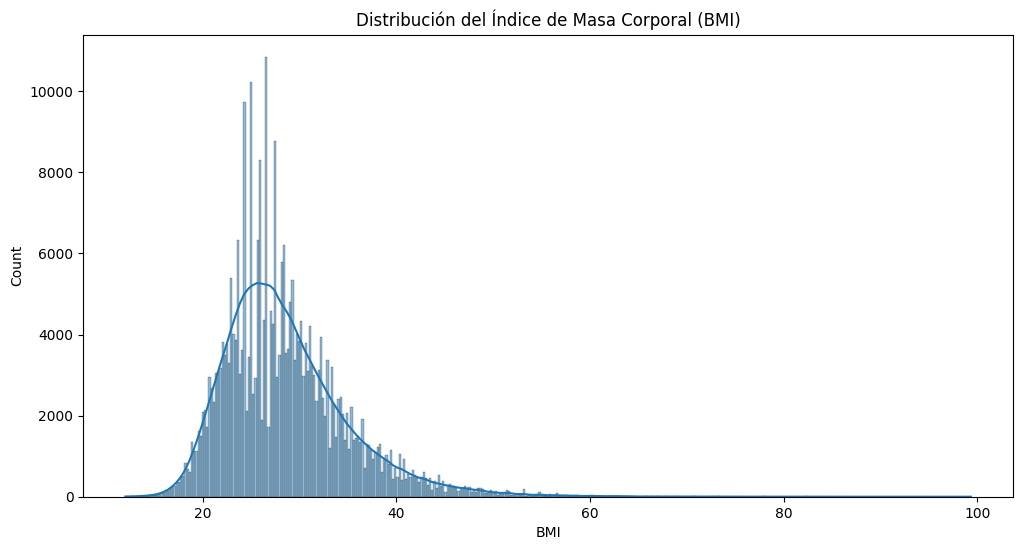

In [4]:
# Conteo de valores para variables categóricas
print(data['General_Health'].value_counts())
print(data['Sex'].value_counts())
print(data['Heart_Disease'].value_counts())

# Visualización de la distribución de las variables numéricas
plt.figure(figsize=(12, 6))
sns.histplot(data['BMI'], kde=True)
plt.title('Distribución del Índice de Masa Corporal (BMI)')
plt.show()


* Pico Central: La distribución tiene un pico pronunciado alrededor de un valor de BMI de aproximadamente 25-30, que se considera en el rango de sobrepeso según los estándares médicos. La concentración alrededor de este rango sugiere que una gran proporción de la población del dataset tiene un BMI en este rango.

* Distribución Asimétrica: La distribución es asimétrica hacia la derecha (sesgo positivo), lo que indica que hay menos individuos con valores de BMI extremadamente altos, pero los que hay pueden ser significativos debido a su mayor riesgo de problemas de salud como enfermedades cardiovasculares.

* Valores Extremos: Hay valores extremos, o outliers, en el extremo derecho del gráfico (algunos con BMI superior a 50), lo que puede indicar obesidad severa. Estos casos son menos frecuentes pero de alto riesgo.

* Colas Largas: La curva tiene una cola larga que se extiende hacia valores más altos de BMI, lo que podría indicar que hay una variedad de estados de obesidad en la población estudiada.

* Rango de BMI 'Normal': Hay una cantidad considerable de la población con un BMI que cae en lo que se consideraría un rango "normal" (aproximadamente 18.5-24.9), lo cual es positivo para la salud cardiovascular.

* Importancia para el Análisis: En el contexto del análisis de enfermedades cardiovasculares, estos datos son significativos porque el BMI es un factor de riesgo conocido para tales condiciones. La distribución muestra que gran parte de la población podría estar en un rango de riesgo más elevado.

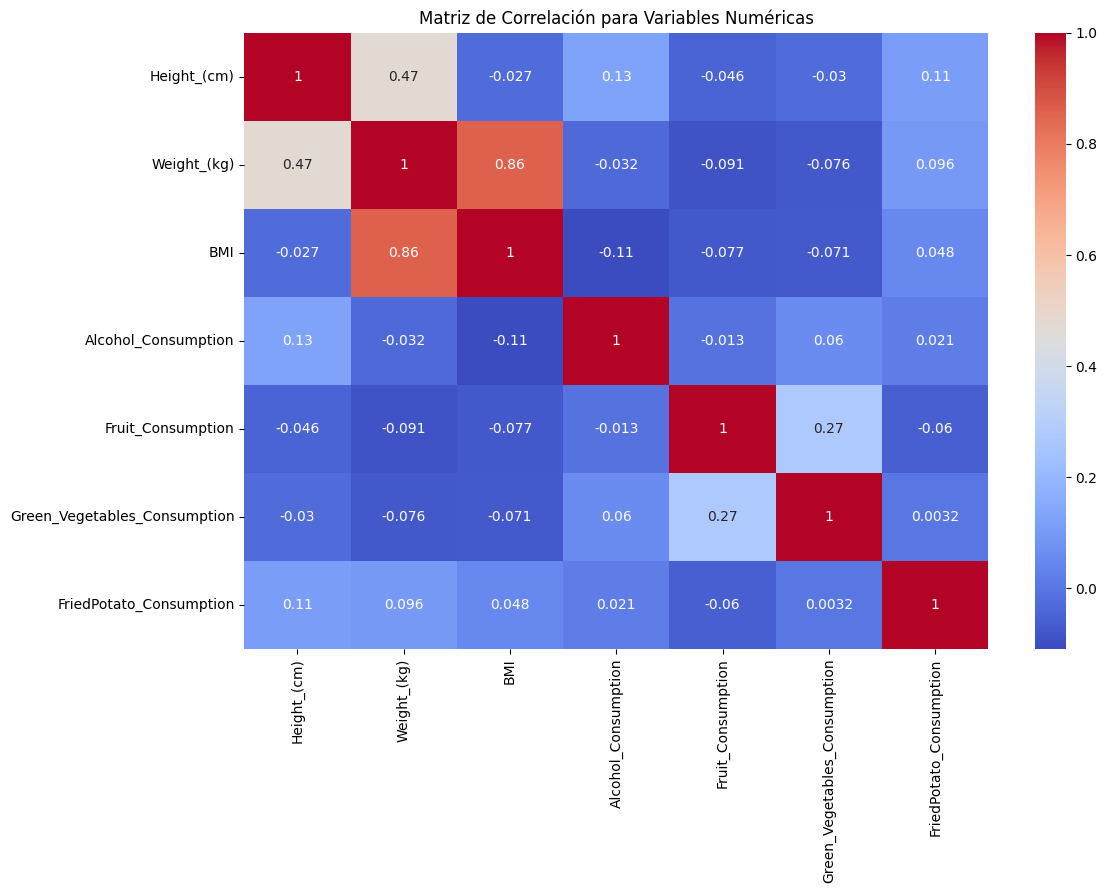

In [12]:

# Matriz de correlación
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()



* Altura y Peso: Existe una correlación moderada de 0.47 entre la altura (Height_(cm)) y el peso (Weight_(kg)), lo cual es de esperar ya que las personas más altas tienden a pesar más.

* Peso y BMI: Hay una correlación muy fuerte de 0.86 entre el peso y el BMI, lo cual tiene sentido ya que el BMI se calcula utilizando el peso y la altura de una persona. Este es un vínculo directo, ya que el BMI es un índice de la relación entre la altura y el peso.

* Consumo de Alcohol y Otras Variables: El consumo de alcohol (Alcohol_Consumption) tiene correlaciones muy bajas con todas las demás variables, sugiriendo que no hay una relación lineal directa fuerte entre el consumo de alcohol y medidas físicas como el peso y la altura o la ingesta de diferentes tipos de alimentos.

* Consumo de Frutas y Verduras: La correlación entre el consumo de frutas (Fruit_Consumption) y el consumo de verduras (Green_Vegetables_Consumption) es de 0.27, lo que indica una correlación positiva modesta. Esto podría sugerir que las personas que consumen más frutas también tienden a consumir más verduras.

* Correlaciones Bajas: Muchas de las correlaciones son muy bajas, cerca de cero. Esto sugiere que no hay una relación lineal fuerte entre muchas de las variables de estilo de vida (como el consumo de alimentos) y las medidas físicas básicas.

In [13]:
# Análisis de valores faltantes
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


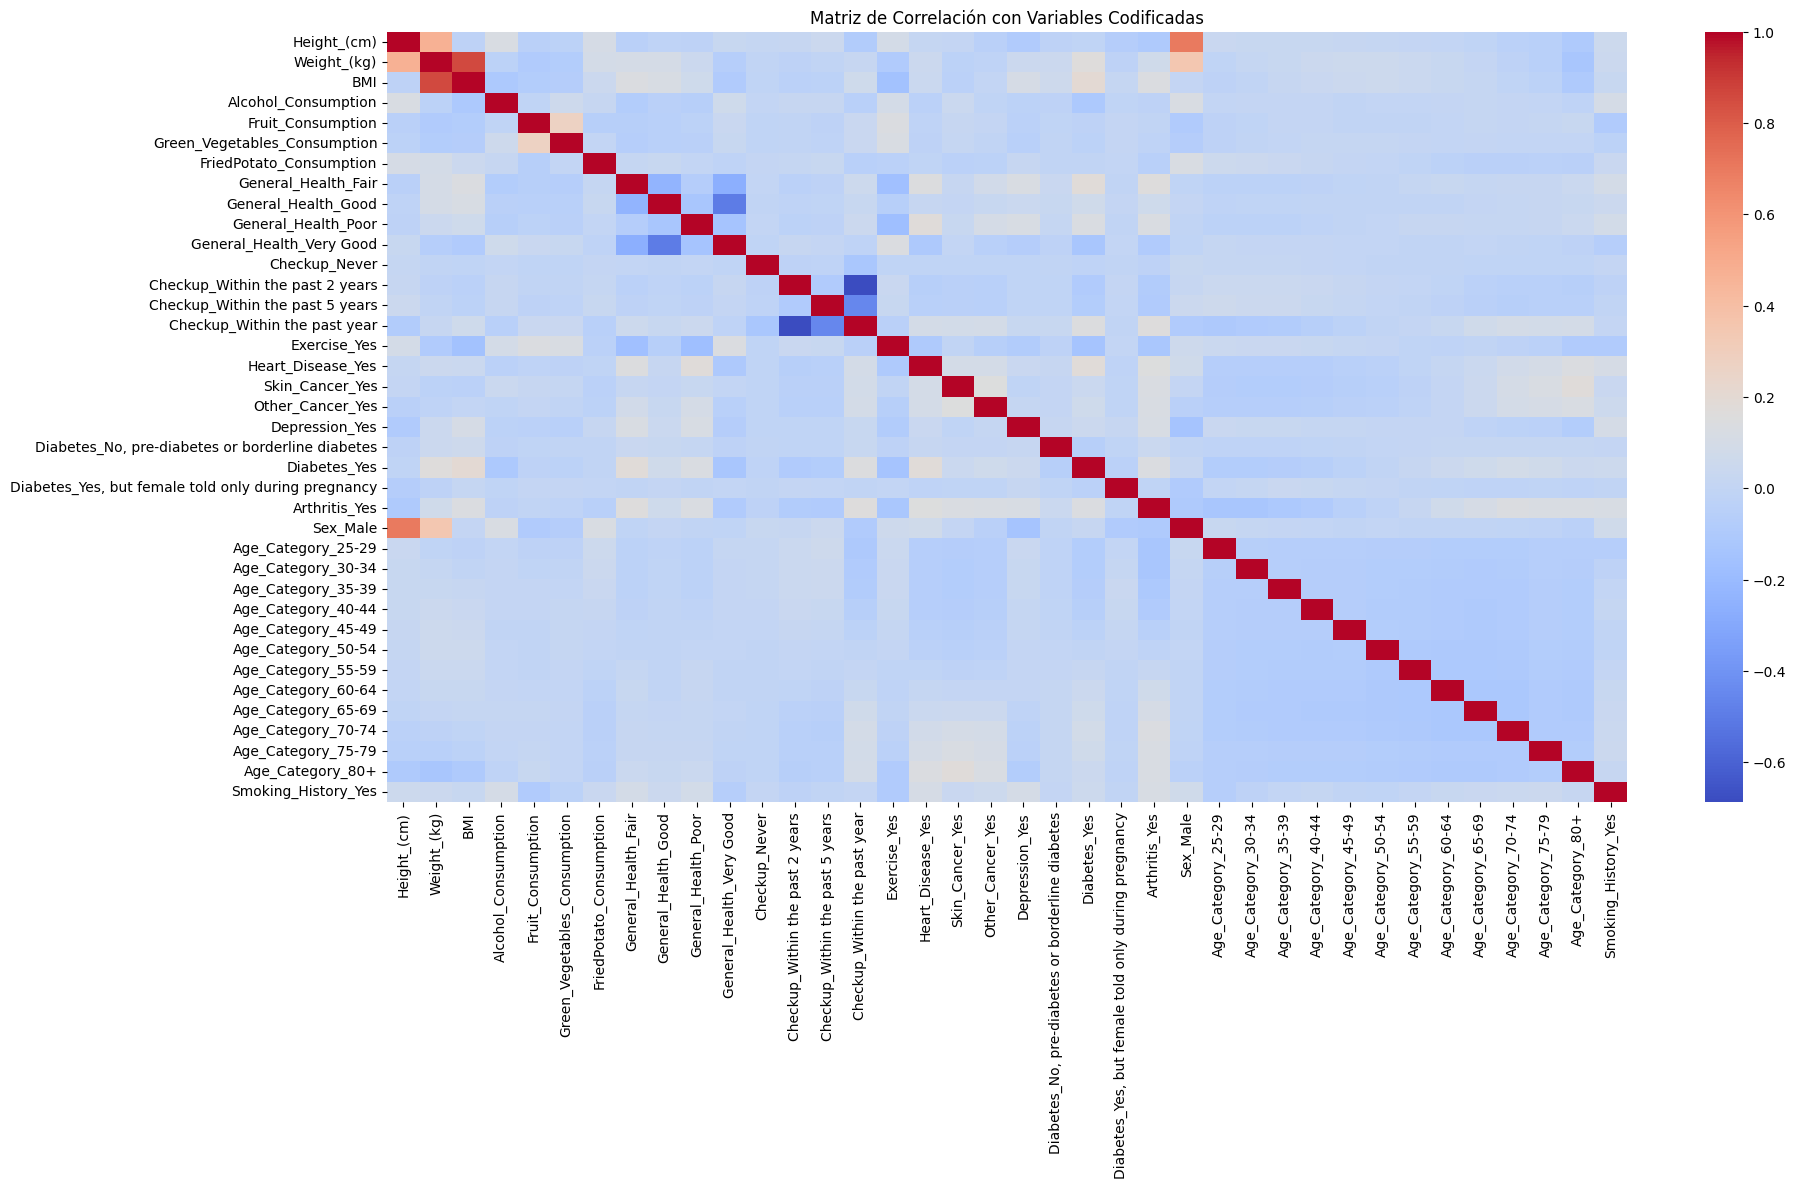

In [7]:
data_encoded = pd.get_dummies(data, drop_first=True)  # drop_first=True para evitar multicolinealidad
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')  # annot=False para evitar desorden en un heatmap grande
plt.title('Matriz de Correlación con Variables Codificadas')
plt.show()

En la gráfica, vemos una matriz de correlación que presenta las relaciones entre variables que han sido codificadas, probablemente para prepararlas para un análisis de aprendizaje automático. Las correlaciones varían entre -1 y 1, donde 1 indica una correlación positiva perfecta, -1 indica una correlación negativa perfecta, y valores cercanos a 0 indican poca o ninguna correlación lineal entre las variables.

En el contexto de un análisis predictivo para enfermedades cardiovasculares, aquí están algunos puntos destacados:

* Edad y enfermedades: Hay bloques de correlación positiva más oscuros que indican una relación entre categorías de edad avanzada y la presencia de varias condiciones, como enfermedades cardiacas y artritis. Esto es esperado, ya que el riesgo de muchas enfermedades aumenta con la edad.

* Estado de salud general: Las variables que representan el auto-reportaje del estado de salud general (por ejemplo, General_Health_Fair, General_Health_Good, etc.) parecen tener una correlación negativa con las condiciones de salud específicas. Esto podría significar que aquellos que reportan un estado de salud mejor tienden a tener menos diagnósticos de enfermedades.

* IMC y peso: El Índice de Masa Corporal (BMI) y el peso (Weight_(kg)) están altamente correlacionados, lo que tiene sentido dado que el BMI se calcula a partir del peso y la altura. El BMI podría tener una relación significativa con las condiciones de salud y es probable que sea una variable importante para el modelado predictivo de enfermedades cardiovasculares.
Comportamientos de salud: Hay algunas correlaciones leves entre variables como la historia de fumar y la salud cardíaca, lo que sugiere posibles factores de riesgo o indicadores de enfermedades cardiovasculares.

* Correlaciones entre enfermedades: Existe una correlación entre diferentes condiciones de salud (por ejemplo, enfermedades del corazón y otros tipos de problemas de salud como diabetes y cáncer de piel)

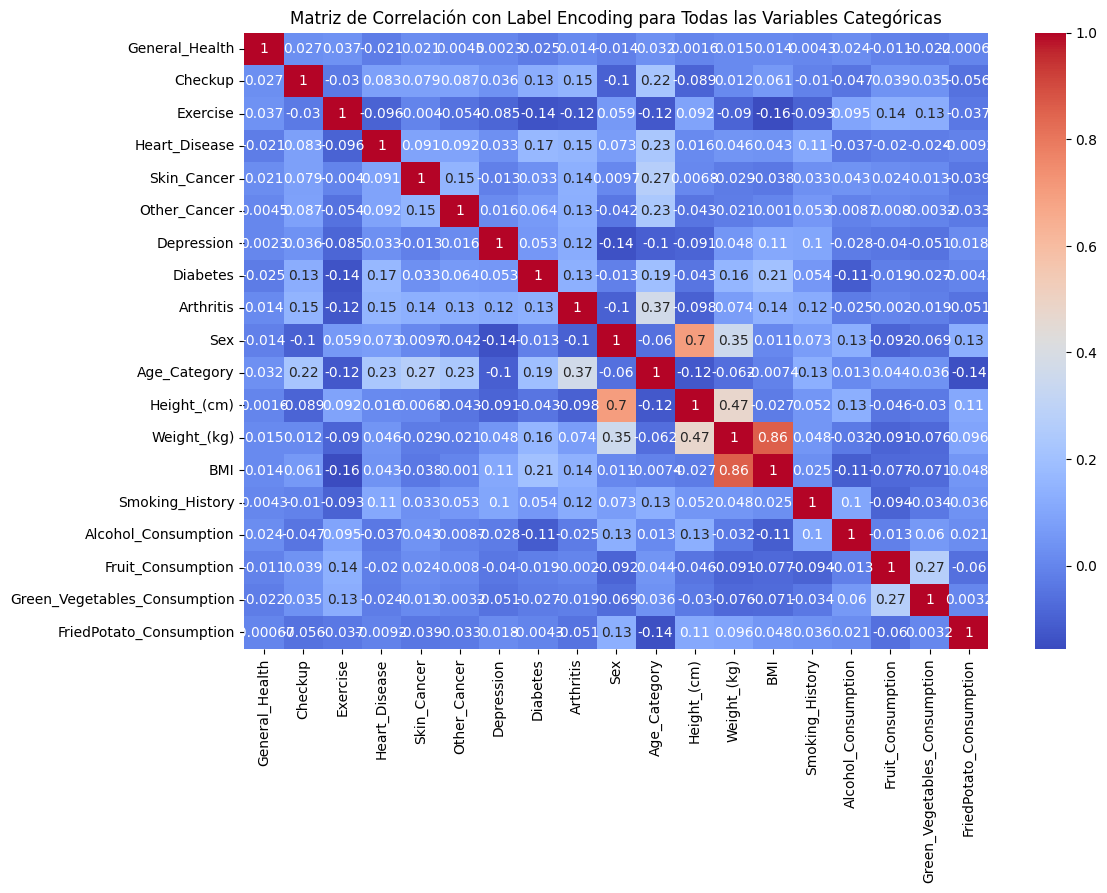

In [10]:
# Copia del dataframe para no alterar el original
data_encoded = data.copy()

# Crear un LabelEncoder para cada columna categórica y aplicarlo
label_encoders = {}

# Identificar columnas categóricas
categorical_cols = data_encoded.select_dtypes(include=['object']).columns

for column in categorical_cols:
    le = LabelEncoder()
    # Ajustar y transformar la columna
    data_encoded[column] = le.fit_transform(data_encoded[column])
    label_encoders[column] = le  # Guardar el encoder si es necesario revertir la transformación

# Calcular la matriz de correlación sobre el dataframe completamente codificado
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación con Label Encoding para Todas las Variables Categóricas')
plt.show()

* Correlaciones Relevantes: Los puntos más importantes a considerar serían las correlaciones de las variables relacionadas con la salud cardiovascular, como el BMI, la presión arterial, y posiblemente otras condiciones médicas o hábitos de vida. Las correlaciones fuertes entre estas variables podrían indicar su importancia en el riesgo de enfermedades cardiovasculares.

* Correlaciones Inversas: Además de las correlaciones positivas, también se deben observar las correlaciones inversas, que se destacarían por tonos más oscuros en la parte inferior izquierda del mapa de calor. Estas correlaciones negativas podrían ser igualmente importantes para comprender la relación entre las variables y su impacto en la salud cardiovascular.

### Análisis de Componentes Principales para Variables Numéricas

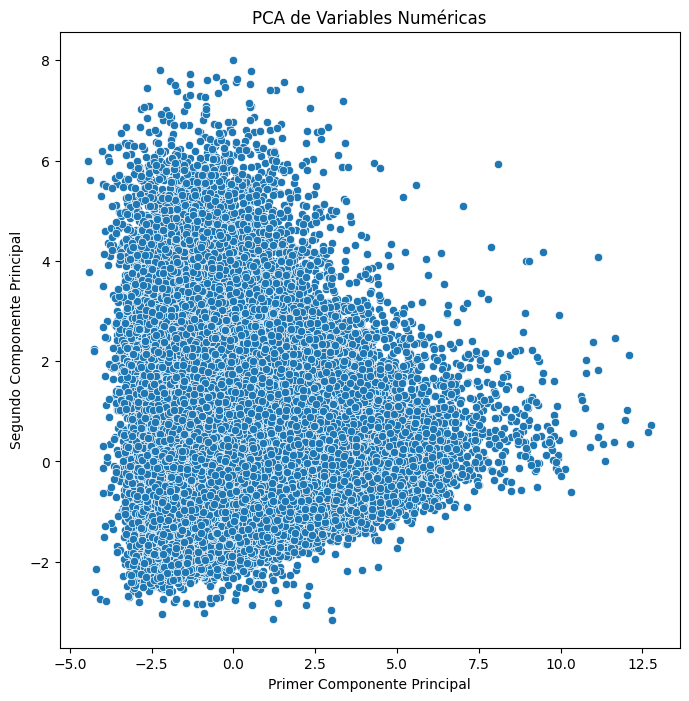

In [7]:


# Verificar si el DataFrame está vacío
if data.empty:
    raise ValueError("El DataFrame está vacío. Comprueba la ruta del archivo CSV y asegúrate de que no esté vacío.")

# Filtrar solo las columnas numéricas
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_cols]

# Verificar si hay columnas numéricas seleccionadas
if numeric_data.empty:
    raise ValueError("No se encontraron columnas numéricas")

# Comprobar si hay valores NaN y cuántos hay
if numeric_data.isnull().any().any():
    print("Hay valores NaN en los datos, se procederá a imputarlos.")
    print(numeric_data.isnull().sum())

# Imputar valores NaN con la mediana
imputer = SimpleImputer(strategy='median')
numeric_data_imputed = imputer.fit_transform(numeric_data)

# Estandarizar los datos imputados
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_data_imputed)

# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(numeric_scaled)
# Crear un DataFrame con los componentes principales para visualización
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualizar
plt.figure(figsize=(8, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA de Variables Numéricas')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.show()

### Análisis Bivariado

El análisis bivariado examina la relación entre cada variable independiente y la variable objetivo. Esto puede incluir gráficos de barras para relaciones categóricas y diagramas de dispersión para relaciones continuas.

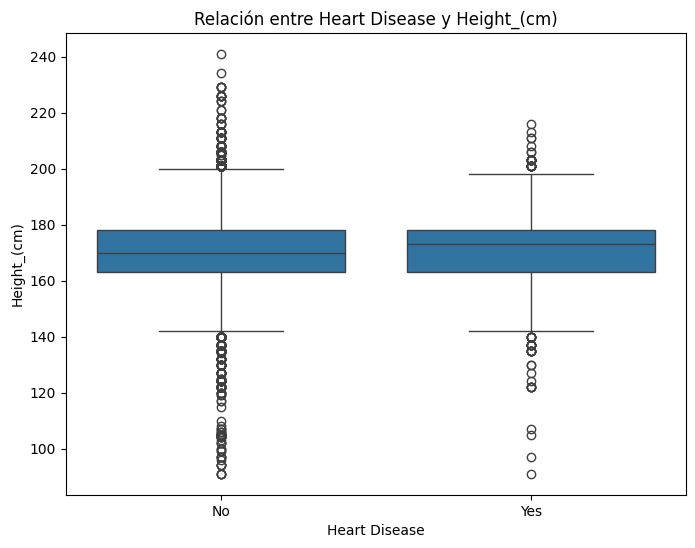

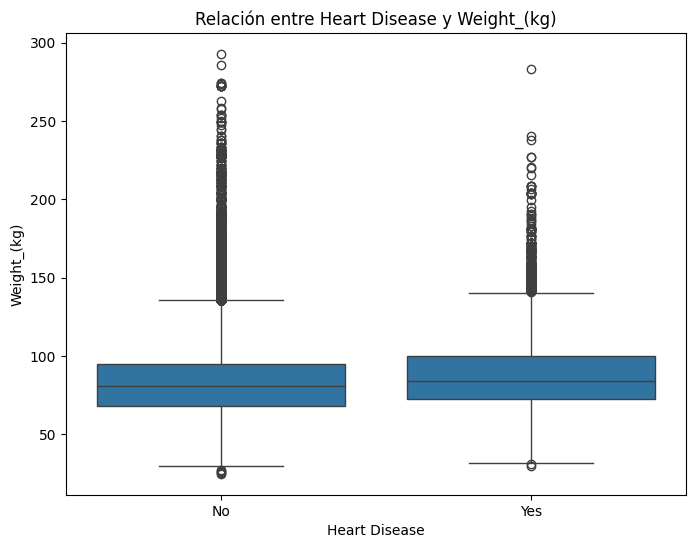

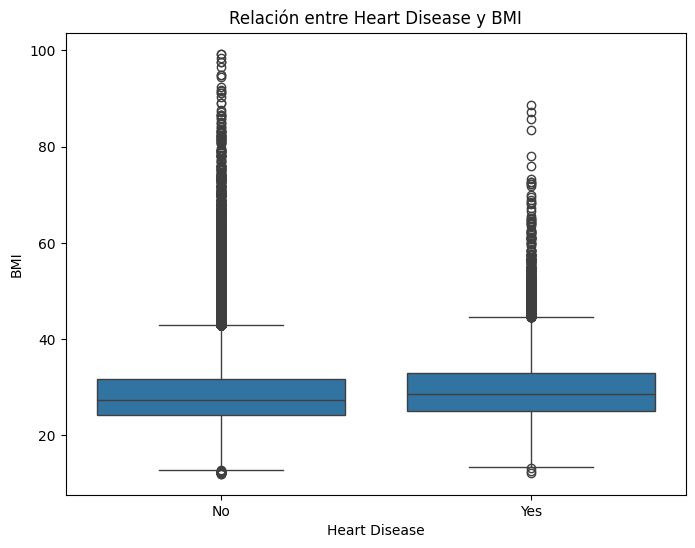

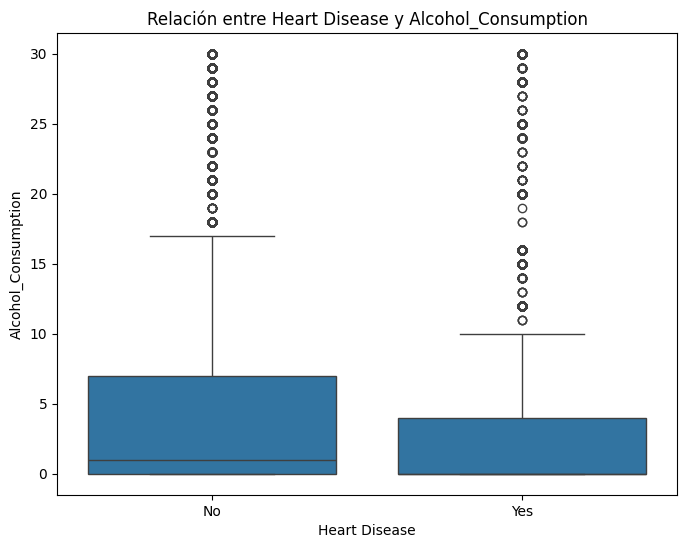

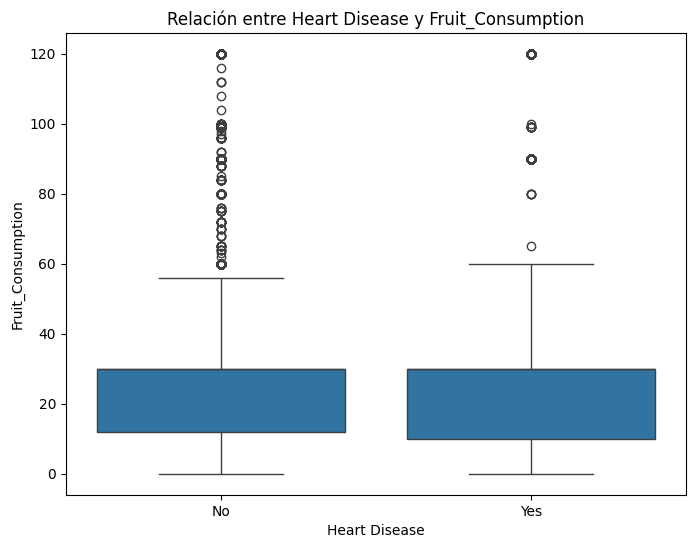

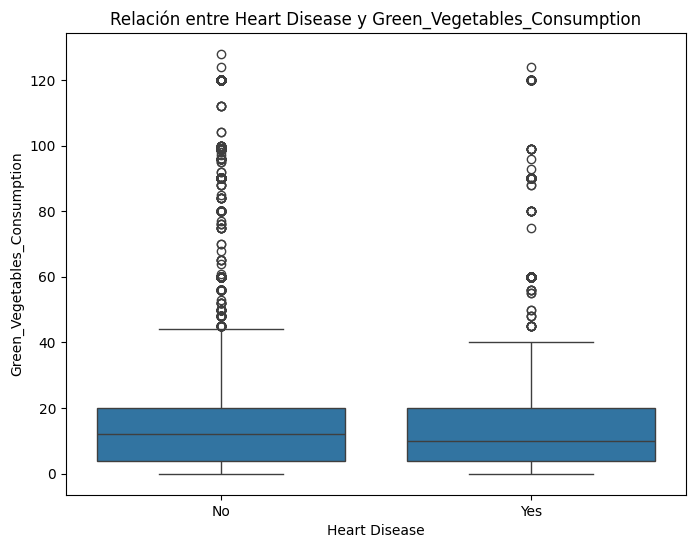

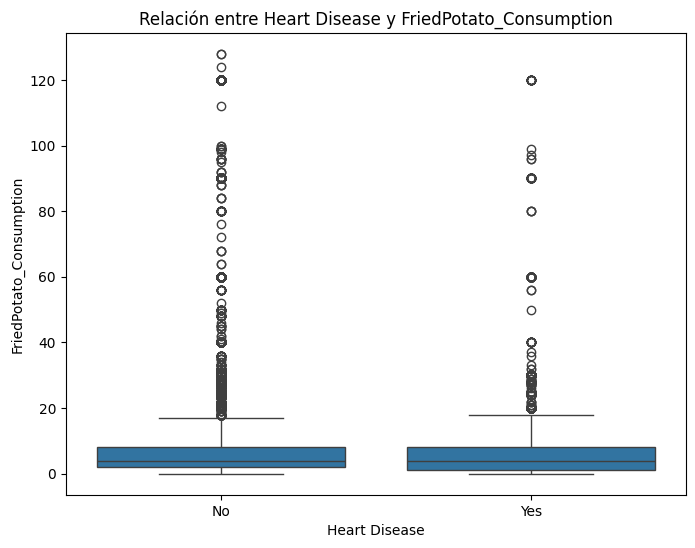

In [12]:
# Análisis bivariado para variables numéricas
for var in numeric_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Heart_Disease', y=var, data=data)
    plt.title(f'Relación entre Heart Disease y {var}')
    plt.xlabel('Heart Disease')
    plt.ylabel(var)
    plt.show()

Analizando el análisis bivariado para variables numéricas podemos sacar ciertas conclusiones.

* Relación entre Heart Disease y Height (cm)
    * Distribución de la altura: Se observa cómo varía la altura de las personas con y sin enfermedad cardíaca. 
    * En cuanto a las medianas (la línea dentro del boxplot) presentan diferencias ligeras estando la mediana del grupo que no presenta ninguna complicación en torno a los 170 cm y en los pacientes que sí presentan enfermedades cardíacas ligeramnete superior. No se cree que esto explique ninguna causalidad de la variable objetivo si no que se puede tratar de un sesgo en los propios datos.
    * Outliers en la altura: Los puntos fuera de las "bigotes" (whiskers) del boxplot indican valores atípicos, lo cual podría sugerir que hay casos extremos en la altura que podrían estar asociados con la enfermedad. En este caso, el mayor número de outliers presentes se encuentran en el grupo que no padecen problemas de corazón.

* Relación entre Heart Disease y Weight (kg)
    * Distribución del peso: se compara el peso de individuos con y sin enfermedad cardíaca. Las cajas o boxes presentes son de un tamaño similar, al igual que la mediana dentro de esta que está en torno a unos ochenta o noventa kilogramos. En cuanto al número de outliers, el grupo que presenta una enfermedad de corazón identifica menos outliers que el que no. Se puede justificar esta diferencia por un sesgo menor en datos.

* Relación entre Heart Disease y BMI
    * Distribución del BMI: El índice de masa corporal (BMI) es un factor importante relacionado con las enfermedades cardíacas. De manera muy similar al caso anterior, tanto el tamaño de los boxes como la posición de la mediana y de los "bigotes" están en rangos muy similares.

* Relación entre Heart Disease y Alcohol_Consumption
    * Consumo de alcohol: Este gráfico podría mostrar si las personas con enfermedad cardíaca tienden a consumir más o menos alcohol que aquellas sin la enfermedad. Si no hay mucha superposición entre los grupos, el consumo de alcohol podría estar asociado con la enfermedad.

* Relación entre Heart Disease y Fruit_Consumption
    * Consumo de frutas: Este análisis podría revelar si existe una relación entre la cantidad de frutas consumidas y la presencia de enfermedades cardíacas, algo que se espera sea un factor de estilo de vida saludable.

* Relación entre Heart Disease y Green_Vegetables_Consumption
    * Consumo de vegetales verdes: Similar al consumo de frutas, este boxplot puede sugerir si el consumo de verduras tiene alguna relación con la salud cardíaca.

* Relación entre Heart Disease y FriedPotato_Consumption
    * Consumo de patatas fritas: Este gráfico podría mostrar la relación entre el consumo de alimentos potencialmente no saludables como las patatas fritas y la enfermedad cardíaca.


Para todas estas gráficas, algunas consideraciones comunes incluyen:

Medianas y cuartiles: La mediana es la línea central en cada caja, y las alturas de las cajas representan los cuartiles (25% y 75% percentiles). Si las medianas están en niveles muy diferentes, eso indica una diferencia central entre los grupos.
Bigotes: Los extremos de los bigotes representan el rango típico de los datos, y los puntos fuera de estos son considerados outliers.
Ancho de las cajas: El ancho de la caja indica la dispersión entre los cuartiles medianos, lo cual puede hablar de la variabilidad de los datos en ese grupo.

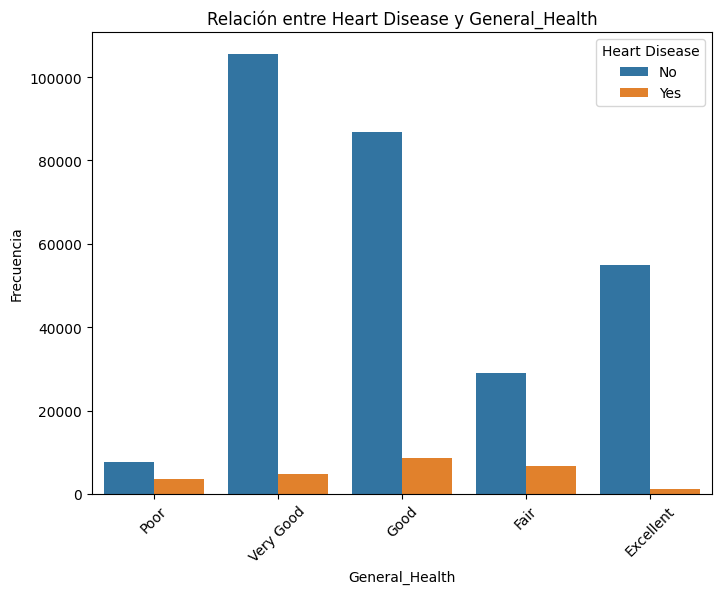

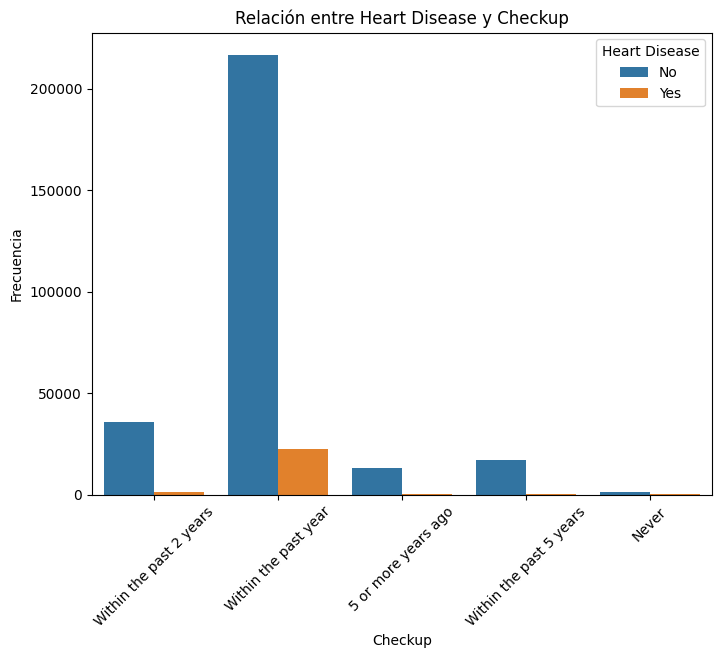

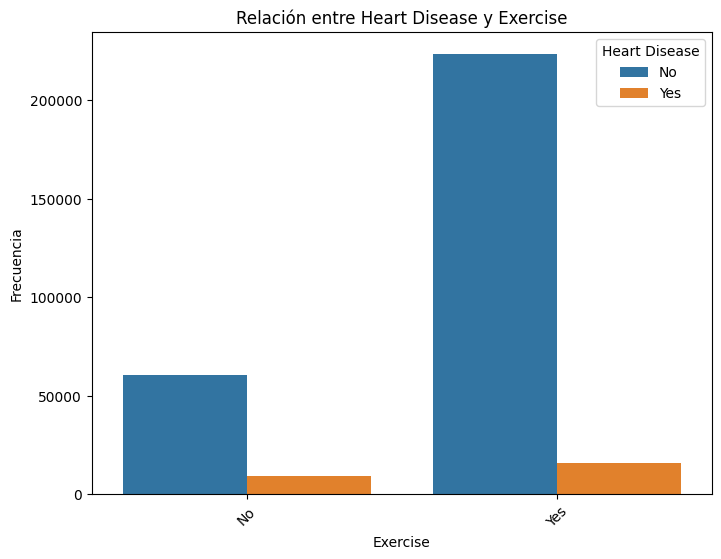

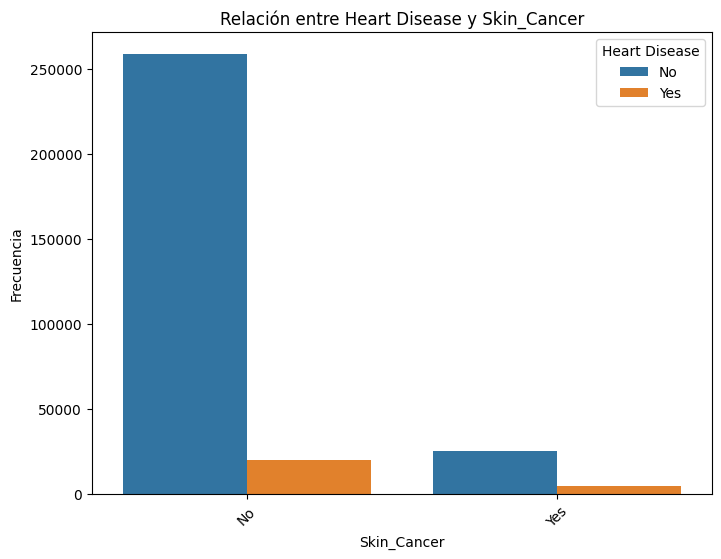

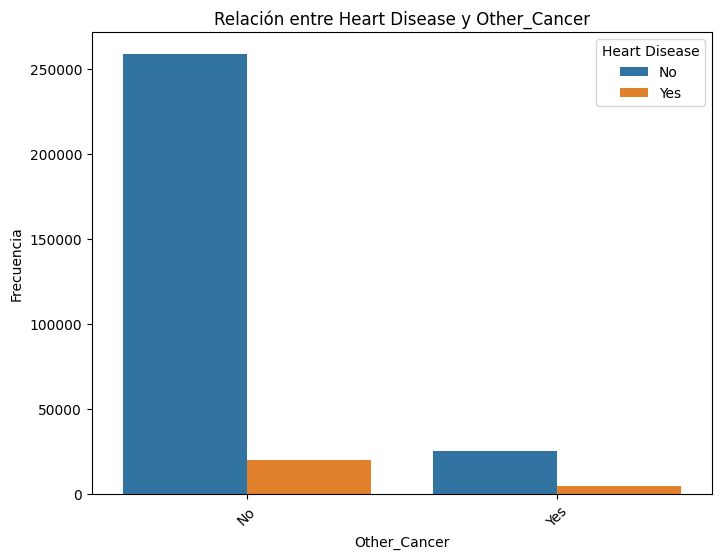

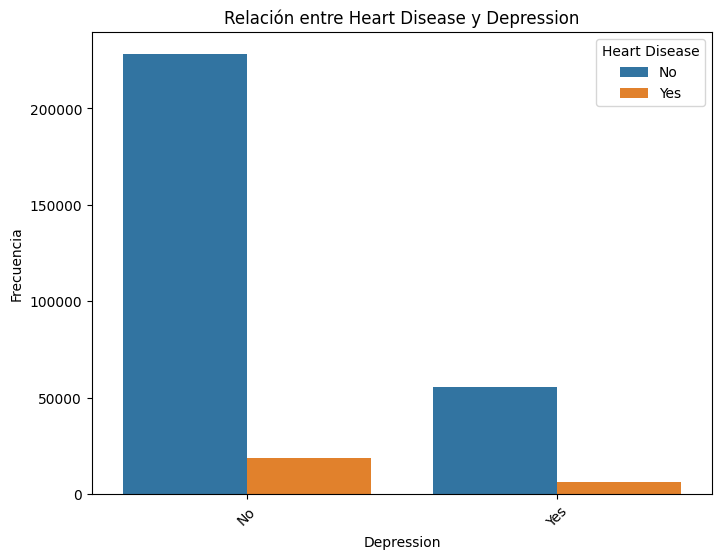

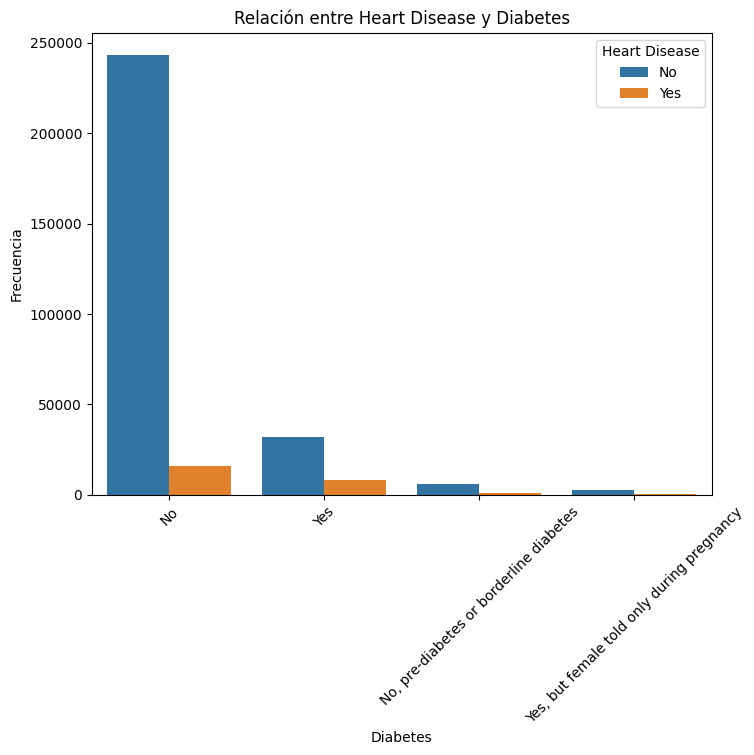

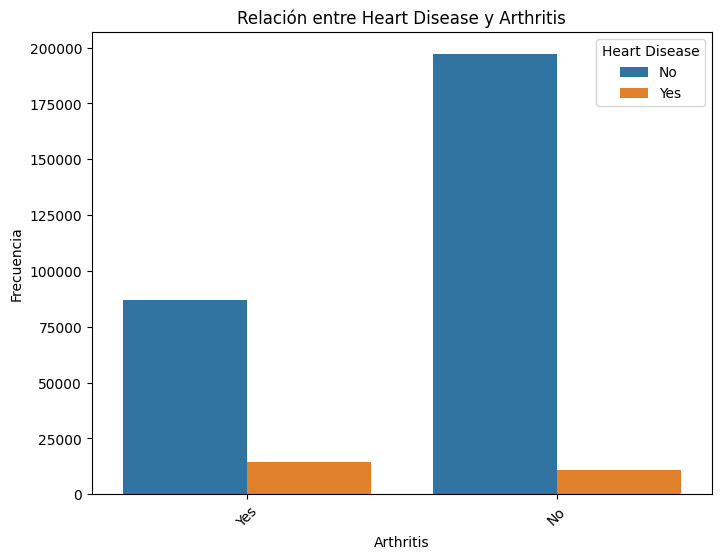

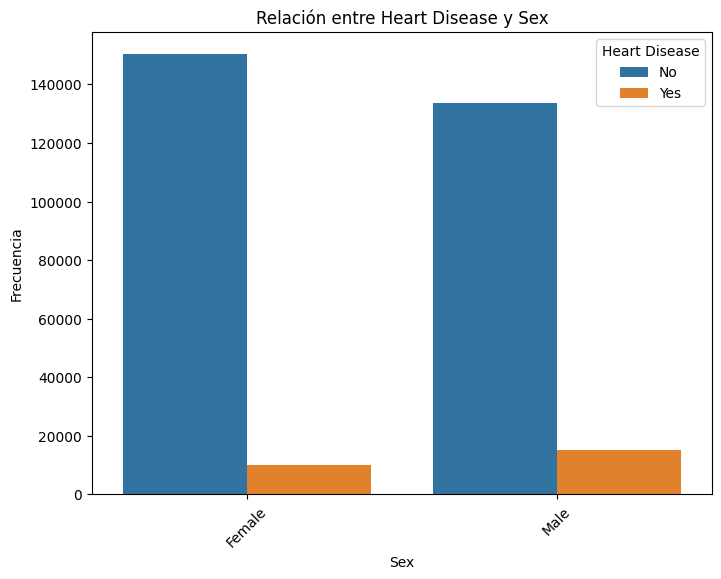

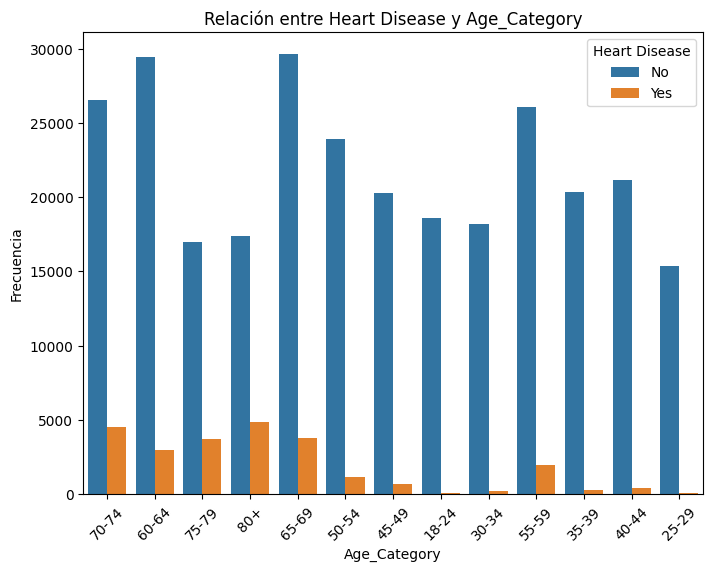

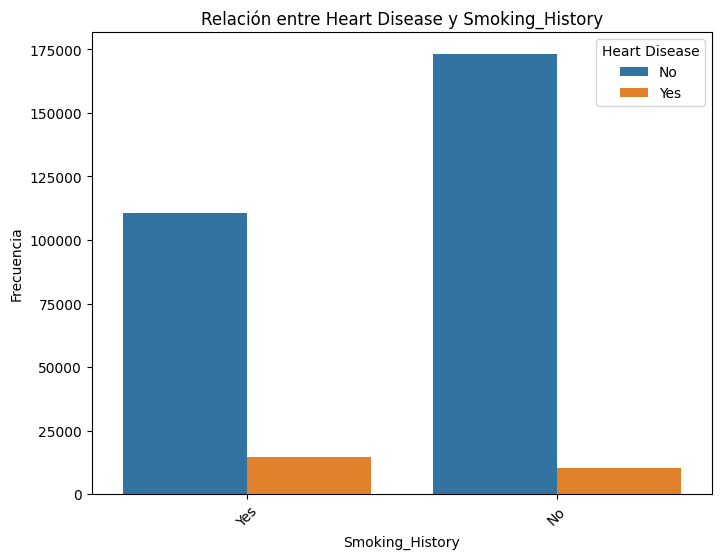

In [13]:
# Análisis bivariado para variables categóricas
for var in categorical_vars:
    if var != 'Heart_Disease':  # Excluimos la variable objetivo
        plt.figure(figsize=(8, 6))
        sns.countplot(x=var, hue='Heart_Disease', data=data)
        plt.title(f'Relación entre Heart Disease y {var}')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.xticks(rotation=45)
        plt.legend(title='Heart Disease')
        plt.show()

## Ingeniería de Características
Para la preparación del dataset, abordaremos los siguientes pasos:

Gestión de valores faltantes: Imputaremos o eliminaremos filas/columnas según sea necesario.
Codificación de variables categóricas: Usaremos técnicas como One-Hot Encoding o Label Encoding.
Normalización/Estandarización de variables: Estandarizaremos las variables numéricas para tener un rango común.

In [5]:
# Lista de variables numéricas y categóricas
numeric_vars = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_vars = data.select_dtypes(include=['object']).columns.tolist()


In [6]:

# Definición de pipelines para transformaciones numéricas y categóricas (One-Hot Encoding)
numeric_transformer_one_hot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_one_hot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinar transformaciones (One-Hot Encoding)
preprocessor_one_hot = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_one_hot, numeric_vars),
        ('cat', categorical_transformer_one_hot, categorical_vars)])

# Aplicar transformaciones (One-Hot Encoding)
data_prepared_one_hot = preprocessor_one_hot.fit_transform(data)

Alternativas como el Ordinal Encoding o el uso de técnicas de embedding pueden ser más adecuadas en ciertas circunstancias. Ordinal Encoding asigna un valor entero único a cada categoría de manera ordenada. Aunque es más compacto y evita el problema de la alta dimensionalidad inherente al One-Hot Encoding, puede introducir una relación de orden artificial entre las categorías que no existe naturalmente, lo cual podría ser inapropiado para algunos modelos. 
Por otro lado, los métodos de embedding, comúnmente empleados en el aprendizaje profundo, pueden aprender una representación numérica densa de las categorías, lo que permite capturar relaciones potencialmente más complejas entre ellas.

Hay que volver a clarificar que el Ordinal Encoding ordena las categorías numéricamente, lo cual puede ser un problema si el modelo interpreta esta ordenación como una relación de magnitud.

In [7]:
# Definición de pipelines para transformaciones numéricas y categóricas (Ordinal Encoding)
numeric_transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())])

# Combinar transformaciones (Ordinal Encoding)
preprocessor_ordinal = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_ordinal, numeric_vars),
        ('cat', categorical_transformer_ordinal, categorical_vars)])

# Aplicar transformaciones (Ordinal Encoding)
data_prepared_ordinal = preprocessor_ordinal.fit_transform(data)


## Aplicación de Modelos
A continuación, definiremos y entrenaremos diferentes modelos, compararemos su rendimiento y seleccionaremos el más adecuado. Después de completar estos pasos iniciales, podemos proceder a la evaluación y mejora de los modelos seleccionados.

* Gestión de valores faltantes: Imputaremos o eliminaremos filas/columnas según sea necesario. Se utiliza para ello 'SimpleImputer' para ambas características numéricas y categóricas, para las numéricas se rellena con la mediana mientras que para las categóricas se utilizan los valores más frecuentes.
* Codificación de variables categóricas: Usaremos técnicas como One-Hot Encoding o Label Encoding. OneHotEncoder se centra en crear nuevas columnas indicando presencia de un valor con un 1 y la ausencia con un 0. La opción de handle_unknown='ignore' permite manejar categorías no vistas durante el entrenamiento.
* Normalización/Estandarización de variables: Estandarizaremos las variables numéricas para tener un rango común. Se utiliza para esto el StandardScaler, es crucial para utilizar modelos que asumen que todas las características tienen aproximadamente la misma escala, como la regresión lineal o métodos en los que sean importante las distancias.

In [8]:
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Smoking_History'],
      dtype='object')


In [9]:
# Define las características numéricas y categóricas
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

# Combina las características numéricas y categóricas en una sola lista
columns_transformed = numeric_features.tolist() + categorical_features.tolist()

# Define el DataFrame con las características transformadas
data_prepared_ordinal_enc_df = pd.DataFrame(data_prepared_ordinal, columns=columns_transformed)

# Define las características y la variable objetivo
X_oe = data_prepared_ordinal_enc_df.drop('Heart_Disease', axis=1)
y_oe = data_prepared_ordinal_enc_df['Heart_Disease']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_oe, y_oe, test_size=0.2, random_state=42)

### XGBoost

* Resampling con SMOTE:
    * SMOTE (Synthetic Minority Over-sampling Technique) es una técnica avanzada de sobremuestreo que ayuda a abordar el desequilibrio de clases creando ejemplos sintéticos de la clase minoritaria en lugar de simplemente hacer un sobremuestreo con reemplazo. Esto se hace seleccionando ejemplos que están cerca en el espacio de características, trazando una línea entre los ejemplos en el espacio de características y generando ejemplos nuevos a lo largo de esa línea.
    * sampling_strategy='minority' indica que solo la clase minoritaria será sobremuestreada para equiparar su número al de la clase mayoritaria.
* Submuestreo con TomekLinks:
    * TomekLinks es una técnica de submuestreo que identifica pares de ejemplos cercanos pero de clases opuestas, conocidos como enlaces Tomek, y elimina los ejemplos de la clase mayoritaria de cada par. Esto puede ayudar a hacer que el límite de decisión entre las clases sea más distinto.
    * sampling_strategy='majority' indica que se submuestreará la clase mayoritaria, eliminando los ejemplos de la clase mayoritaria que son Tomek Links.
* Escalado de Características:
    * MinMaxScaler es utilizado para normalizar las características escalándolas a un rango específico, generalmente 0 a 1. Esto es especialmente útil para algoritmos que dependen de la distancia entre los datos, como K-Nearest Neighbors, y puede mejorar el rendimiento de muchos otros modelos.
* Calculando scale_pos_weight:
    Esta es una técnica específica para algoritmos que soportan ponderación de clases, como XGBoost. El scale_pos_weight se utiliza para contrarrestar el desequilibrio entre las clases ajustando la importancia que se da a las clases minoritarias durante el entrenamiento. Aquí se calcula como la proporción del número de ejemplos en la clase mayoritaria dividido por el número de ejemplos en la clase minoritaria, usando los datos de entrenamiento (y_train).
* Modelo XGBoost Classifier:
    * XGBClassifier es un modelo basado en árboles de gradient boosting que es muy eficaz para una amplia gama de problemas de clasificación.
    * scale_pos_weight ajustado ayuda a tratar con clases desequilibradas.
    * eval_metric='logloss' es la métrica de evaluación para optimizar durante el entrenamiento; logloss es útil para clasificación porque penaliza las clasificaciones incorrectas.
    * use_label_encoder=False se especifica para evitar advertencias ya que XGBoost puede manejar etiquetas codificadas sin necesidad de un codificador de etiquetas adicional.
    * ImbPipeline de imblearn:
    A diferencia de Pipeline de scikit-learn, ImbPipeline está diseñado para trabajar con técnicas de remuestreo integradas como SMOTE y TomekLinks. Asegura que el remuestreo solo ocurra durante el entrenamiento del modelo y no durante el proceso de validación o prueba, evitando así el riesgo de filtración de información.

In [32]:
# Define el pipeline con el escalador, XGBClassifier y el remuestreo de clases si es necesario
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=1234, use_label_encoder=False, eval_metric='logloss'))
])

# Define los hiperparámetros a probar para XGBClassifier
parameters_xgb = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 4, 5]
}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_xgb = GridSearchCV(pipeline_xgb, parameters_xgb, cv=5, scoring='recall', verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para XGBoost:")
print(grid_search_xgb.best_params_)
print("Mejor puntuación para XGBoost:")
print(grid_search_xgb.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros para XGBoost:
{'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 300}
Mejor puntuación para XGBoost:
0.055321793704323684


#### Sin utilizar los parámetros

In [42]:
# Define the pipeline
resampling = SMOTE(sampling_strategy='minority')  # Estrategia de re-muestreo para la clase minoritaria
tomek = TomekLinks(sampling_strategy='majority')  # Estrategia de submuestreo para la clase mayoritaria
scaler = MinMaxScaler()

# Usamos y_train para calcular el balance de clases para el parámetro scale_pos_weight
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)  # Ajuste de pesos de clase debido al desequilibrio de clases

model = XGBClassifier(scale_pos_weight=scale_pos_weight,
                      eval_metric='logloss',  # Usar logloss para evaluar el rendimiento
                      use_label_encoder=False)  # Para evitar mensajes de advertencia

# Se debe usar ImbPipeline de imblearn para integrar SMOTE y TomekLinks correctamente
pipeline = ImbPipeline([
    ('MinMaxScale', scaler),
    ('SMOTE', resampling),
    ('TomekLinks', tomek),
    ('Model', model)
])

In [40]:
pipeline.fit(X_train, y_train)

# Aplicar el pipeline: predicción
y_pred = pipeline.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]


              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82     56774
         1.0       0.19      0.79      0.31      4997

    accuracy                           0.72     61771
   macro avg       0.58      0.75      0.57     61771
weighted avg       0.91      0.72      0.78     61771



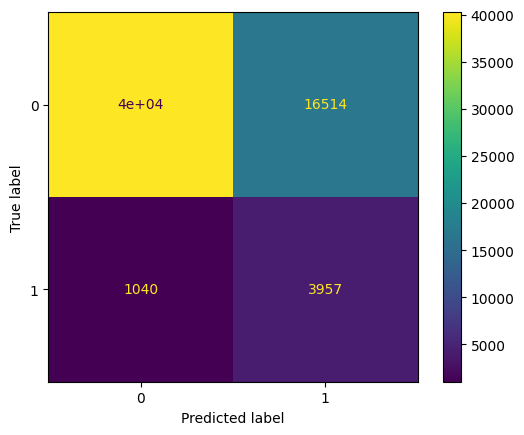

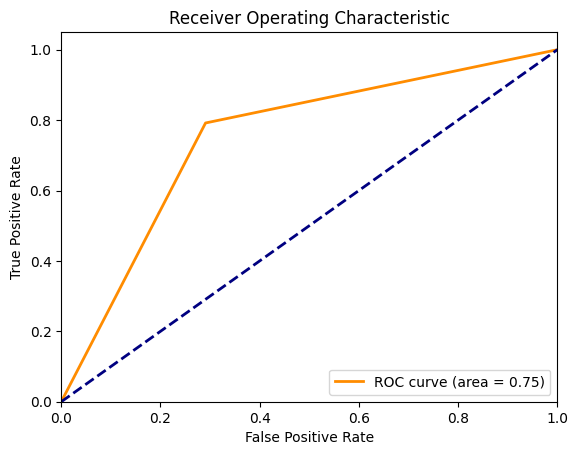

In [41]:

# Print the classification report
report = classification_report(y_test, y_pred)
print(report)

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot the confusion matrix
disp.plot()
plt.show()


# Compute ROC curve and ROC area
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

* Matriz de Confusión
    La matriz de confusión muestra la siguiente información:

    * Verdaderos positivos para la clase 0: 40,000 (aproximadamente) casos fueron correctamente clasificados como clase 0.
    * Falsos positivos para la clase 0: 16,514 casos fueron incorrectamente clasificados como clase 0 cuando en realidad son clase 1.
    * Falsos negativos para la clase 0: 1,032 casos fueron incorrectamente clasificados como clase 1 cuando en realidad son clase 0.
    * Verdaderos positivos para la clase 1: 3,965 casos fueron correctamente clasificados como clase 1.
    
    Esto indica que el clasificador tiene una tasa alta de falsos positivos al predecir la clase 0.

* Curva ROC
    La Curva Característica Operativa del Receptor (ROC) muestra la relación entre la Tasa de Verdaderos Positivos (TPR, o sensibilidad) y la Tasa de Falsos Positivos (FPR, o 1-especificidad) a diferentes umbrales. Un área bajo la curva ROC (AUC) de 0.75 indica un buen rendimiento del clasificador. Cuanto más se acerque el AUC a 1, mejor será el modelo para distinguir entre las dos clases.

* Informe de Clasificación

El reporte de clasificación proporciona las siguientes métricas:

* Precisión para la clase 0: El 98% del tiempo que el modelo predijo la clase 0, estaba en lo correcto.
* Recall para la clase 0: El modelo capturó correctamente el 71% de todas las instancias reales de la clase 0.
* F1-Score para la clase 0: Una medida combinada de precisión y recall que da un puntaje de 0.82, que es bastante alto y sugiere un buen equilibrio entre precisión y recall para la clase 0.

* Precisión para la clase 1: Sólo el 19% del tiempo que el modelo predijo la clase 1, estaba en lo correcto.
* Recall para la clase 1: El modelo capturó correctamente el 79% de todas las instancias reales de la clase 1.
* F1-Score para la clase 1: El puntaje F1 es 0.31, lo que sugiere que mientras el modelo es relativamente bueno identificando la clase 1 entre todos los casos positivos reales, no es muy preciso en sus predicciones para esta clase.

La precisión global (accuracy) del modelo es del 72%, lo que indica que el modelo predijo la clase correcta aproximadamente 3 de cada 4 veces.

El promedio macro de precisión, recall y F1-score es de 0.58, 0.75 y 0.57 respectivamente, lo que sugiere un desempeño bastante equilibrado para las dos clases en términos de recall, pero una gran variación en la precisión y el F1-score, lo que probablemente se debe al desequilibrio de las clases.

El promedio ponderado tiene en cuenta el soporte de cada clase y proporciona una imagen más representativa del desempeño global del modelo, con valores de precisión, recall y F1-score ligeramente más altos que el promedio macro.

identificar correctamente los casos negativos de la clase 0, pero lucha con la precisión para la clase 1, lo que resulta en una cantidad significativa de falsos positivos. Esto puede ser un resultado directo del desequilibrio de clases en tus datos. A pesar de la alta sensibilidad para la clase 1, el modelo necesita mejorar en precisión para ser más efectivo en la práctica, especialmente si los costos de los falsos positivos son altos. El buen AUC sugiere que el modelo tiene un buen rendimiento en la clasificación de las clases en general, pero podría necesitar un ajuste del umbral de decisión para equilibrar mejor las métricas de rendimiento para ambas clases.

Debido a estos resultados vamos a:

* Ajuste de Hiperparámetros de XGBoost: vamos a realizar una búsqueda exhaustiva de hiperparámetros (como GridSearchCV o RandomizedSearchCV) para encontrar la mejor configuración del modelo XGBoost. Parámetros como max_depth, min_child_weight, gamma, subsample, y colsample_bytree pueden tener un gran impacto en el rendimiento.
* Ajuste de Umbral: Modificar el umbral de clasificación para la clase positiva. Por defecto, este umbral es 0.5, pero puedes aumentarlo o disminuirlo para mejorar la precisión o el recall, según lo que sea más importante para tu aplicación específica.

#### Utilizando los parámetros

In [43]:
# Define el pipeline para el preprocesamiento y el modelo XGBoost
resampling = SMOTE(sampling_strategy='minority')  # Estrategia de re-muestreo para la clase minoritaria
tomek = TomekLinks(sampling_strategy='majority')  # Estrategia de submuestreo para la clase mayoritaria
scaler = MinMaxScaler()

# Ajuste de pesos de clase debido al desequilibrio de clases
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Definición del modelo con los mejores parámetros encontrados
best_xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight,
                               eval_metric='logloss',  
                               learning_rate=0.2, 
                               max_depth=5, 
                               n_estimators=300, 
                               use_label_encoder=False,
                               class_weight='balanced')  # Añadimos class_weight='balanced' para ver si mejora


# Se debe usar ImbPipeline de imblearn para integrar SMOTE y TomekLinks correctamente
pipeline = ImbPipeline([
    ('MinMaxScale', scaler),
    ('SMOTE', resampling),
    ('TomekLinks', tomek),
    ('Model', best_xgb_model)
])

In [45]:
pipeline.fit(X_train, y_train)

# Aplicar el pipeline: predicción
y_pred_sgb_param = pipeline.predict(X_test)
#y_score_sgb_param = model.predict_proba(X_test)[:,1]


              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     56774
         1.0       0.20      0.79      0.32      4997

    accuracy                           0.72     61771
   macro avg       0.59      0.76      0.57     61771
weighted avg       0.91      0.72      0.79     61771



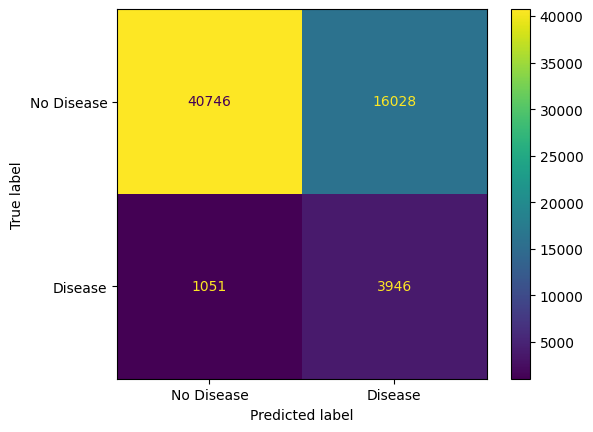

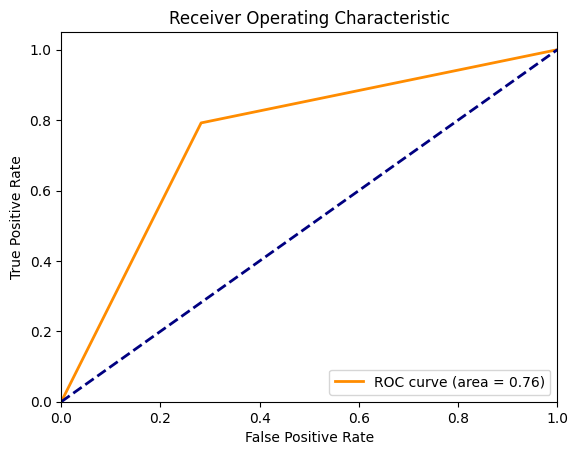

In [47]:
# Print the classification report
report = classification_report(y_test, y_pred_sgb_param)
print(report)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])

# Plot the confusion matrix
disp.plot()
plt.show()

# Compute ROC curve and ROC area
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_sgb_param)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Resultados sin clase balanceada
precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     56774
         1.0       0.20      0.79      0.32      4997

    accuracy                           0.72     61771
   macro avg       0.59      0.76      0.57     61771
weighted avg       0.91      0.72      0.79     61771

#### Intento de balancear los datos

### RandomForest

Ajuste de Hiperparámetro: Si aún no lo has hecho, realizar una búsqueda exhaustiva de hiperparámetros (como GridSearchCV o RandomizedSearchCV) para encontrar la mejor configuración del modelo

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56774
         1.0       0.43      0.02      0.04      4997

    accuracy                           0.92     61771
   macro avg       0.67      0.51      0.50     61771
weighted avg       0.88      0.92      0.88     61771



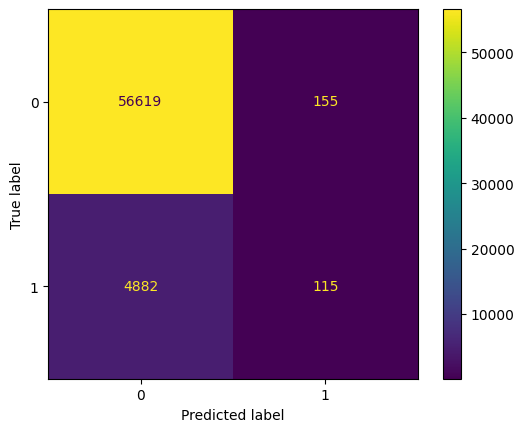

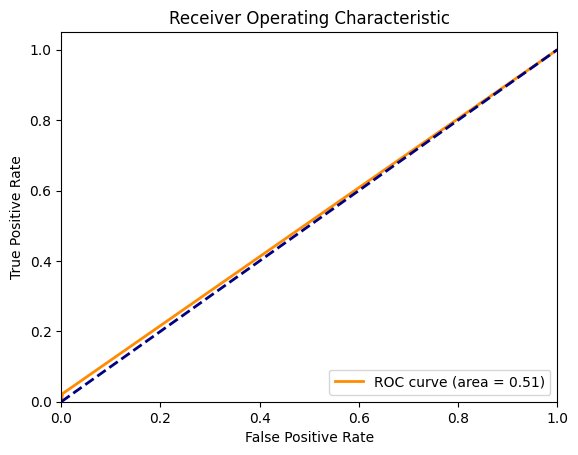

In [29]:

# Asumiendo que X_oe e y_oe son tus datos de características y etiquetas ya preparados:
X_train, X_test, y_train, y_test = train_test_split(X_oe, y_oe, test_size=0.2, random_state=42)

# Crear el modelo Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100,  # Número de árboles
                                             random_state=42,   # Semilla para la reproducibilidad
                                             class_weight='balanced')  # Para manejar clases desbalanceadas

# Entrenar el modelo
random_forest_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test)

# Calcular métricas de rendimiento
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)

# Mostrar la matriz de confusión
disp_rf.plot()
plt.show()

# Compute ROC curve and ROC area
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_rf)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [50]:
# Define el pipeline con el escalador, RandomForestClassifier y el remuestreo de clases si es necesario

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=1234, class_weight='balanced'))
])

# Define los hiperparámetros a probar para RandomForestClassifier
parameters_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, parameters_rf, cv=5, scoring='recall', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para RandomForestClassifier:")
print(grid_search_rf.best_params_)
print("Mejor puntuación para RandomForestClassifier:")
print(grid_search_rf.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros para RandomForestClassifier:
{'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Mejor puntuación para RandomForestClassifier:
0.7866226122663345


              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     56774
         1.0       0.22      0.66      0.33      4997

    accuracy                           0.78     61771
   macro avg       0.59      0.72      0.60     61771
weighted avg       0.90      0.78      0.82     61771



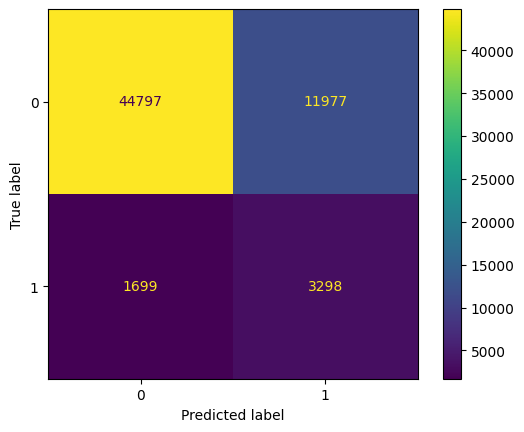

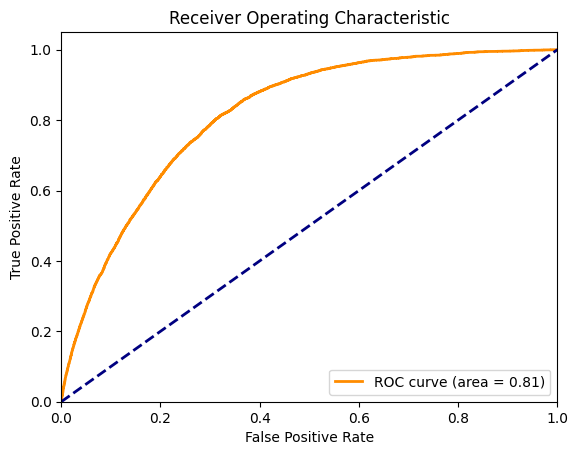

In [52]:
# Define los pasos del pipeline
resampling = SMOTE(sampling_strategy='minority')
tomek = TomekLinks(sampling_strategy='majority')
scaler = MinMaxScaler()

# Crear el modelo Random Forest con los mejores parámetros
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10,
                                              random_state=42, class_weight='balanced')

# Definir el pipeline
pipeline = ImbPipeline([
    ('MinMaxScale', scaler),
    ('SMOTE', resampling),
    ('TomekLinks', tomek),
    ('Model', random_forest_model)
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = pipeline.predict(X_test)

# Calcular métricas de rendimiento
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)

# Mostrar la matriz de confusión
disp_rf.plot()
plt.show()

# Calcular y mostrar el área bajo la curva ROC
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros para Logistic Regression:
{'lr__C': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Mejor puntuación para Logistic Regression:
0.026985196192285926
Informe de clasificación para Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56774
         1.0       0.49      0.03      0.05      4997

    accuracy                           0.92     61771
   macro avg       0.70      0.51      0.50     61771
weighted avg       0.89      0.92      0.88     61771



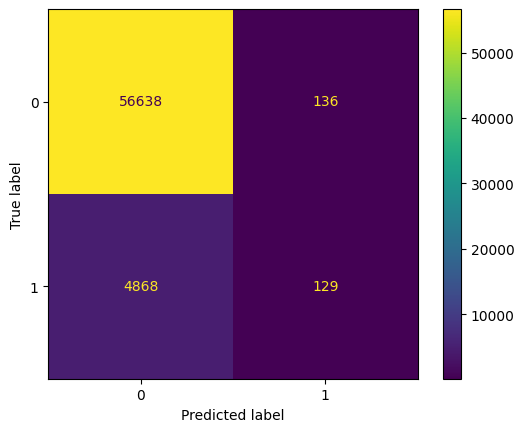

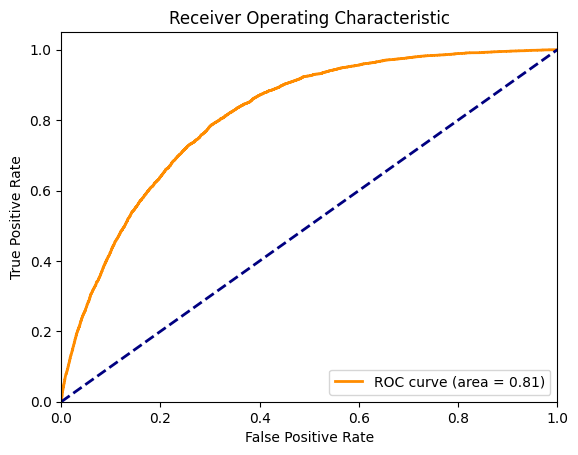

In [56]:

# Define el pipeline con el escalador y LogisticRegression
pipeline_lr = Pipeline([
    ('scaler', scaler),
    #('SMOTE', resampling),
    #('TomekLinks', tomek),
    ('lr', LogisticRegression(random_state=1234))
])

pipeline_lr_smote = Pipeline([
    ('scaler', scaler),
    #('SMOTE', resampling),
    #('TomekLinks', tomek),
    ('lr', LogisticRegression(random_state=1234))
])

# Define los hiperparámetros a probar para LogisticRegression
parameters_lr = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__solver': ['liblinear', 'saga'],
    'lr__penalty': ['l1', 'l2']
}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=5, scoring='recall', verbose=1)
grid_search_lr.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para Logistic Regression:")
print(grid_search_lr.best_params_)
print("Mejor puntuación para Logistic Regression:")
print(grid_search_lr.best_score_)

# Entrena el modelo con los mejores parámetros encontrados
best_lr_model = grid_search_lr.best_estimator_
best_lr_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_lr = best_lr_model.predict(X_test)

# Calcular métricas de rendimiento
report_lr = classification_report(y_test, y_pred_lr)
print("Informe de clasificación para Logistic Regression:")
print(report_lr)

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)

# Mostrar la matriz de confusión
disp_lr.plot()
plt.show()

# Calcular y mostrar el área bajo la curva ROC
y_pred_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_oe, y_oe, test_size=0.2, random_state=42)

# Define el pipeline con el escalador y SVC
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=1234, probability=True, class_weight = "balanced"))
])

# Define los hiperparámetros a probar para SVC
parameters_svc = {
    'svc__C': [0.1], #, 1
    'svc__kernel': ['linear'] #, 'rbf'
}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_svc = GridSearchCV(pipeline_svc, parameters_svc, cv=5, scoring='recall', verbose=1)
grid_search_svc.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para Support Vector Machine:")
print(grid_search_svc.best_params_)
print("Mejor puntuación para Support Vector Machine:")
print(grid_search_svc.best_score_)

# Entrena el modelo con los mejores parámetros encontrados
best_svc_model = grid_search_svc.best_estimator_
best_svc_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_svc = best_svc_model.predict(X_test)

# Calcular métricas de rendimiento
report_svc = classification_report(y_test, y_pred_svc)
print("Informe de clasificación para Support Vector Machine:")
print(report_svc)

# Matriz de confusión
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)

# Mostrar la matriz de confusión
disp_svc.plot()
plt.show()

# Calcular y mostrar el área bajo la curva ROC
y_pred_proba_svc = best_svc_model.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_proba_svc)
roc_auc_svc = roc_auc_score(y_test, y_pred_proba_svc)

plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
print("je")

### Redes Neuronales

In [59]:

# Define el pipeline con el escalador y MLPClassifier
pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(random_state=1234))
])

# Define los hiperparámetros a probar para MLPClassifier
parameters_nn = {
    'nn__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 100)],
    'nn__activation': ['logistic', 'tanh', 'relu'],
    'nn__solver': ['lbfgs', 'adam'],
    'nn__alpha': [0.0001, 0.001, 0.01]
}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_nn = GridSearchCV(pipeline_nn, parameters_nn, cv=5, scoring='recall', verbose=1)
grid_search_nn.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para Redes Neuronales:")
print(grid_search_nn.best_params_)
print("Mejor puntuación para Redes Neuronales:")
print(grid_search_nn.best_score_)

# Entrena el modelo con los mejores parámetros encontrados
best_nn_model = grid_search_nn.best_estimator_
best_nn_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_nn = best_nn_model.predict(X_test)

# Calcular métricas de rendimiento
report_nn = classification_report(y_test, y_pred_nn)
print("Informe de clasificación para Redes Neuronales:")
print(report_nn)

# Matriz de confusión
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)

# Mostrar la matriz de confusión
disp_nn.plot()
plt.show()

# Calcular y mostrar el área bajo la curva ROC
y_pred_proba_nn = best_nn_model.predict_proba(X_test)[:, 1]
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn)
roc_auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_pe

### Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores parámetros para Naive Bayes:
{}
Mejor puntuación para Naive Bayes:
0.4303099831223681
Informe de clasificación para Naive Bayes:
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     56774
         1.0       0.23      0.44      0.30      4997

    accuracy                           0.83     61771
   macro avg       0.59      0.65      0.60     61771
weighted avg       0.89      0.83      0.86     61771



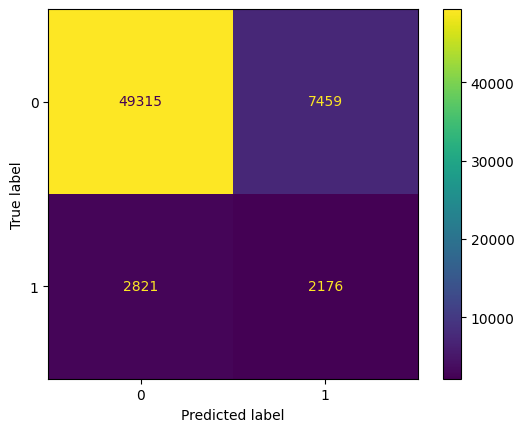

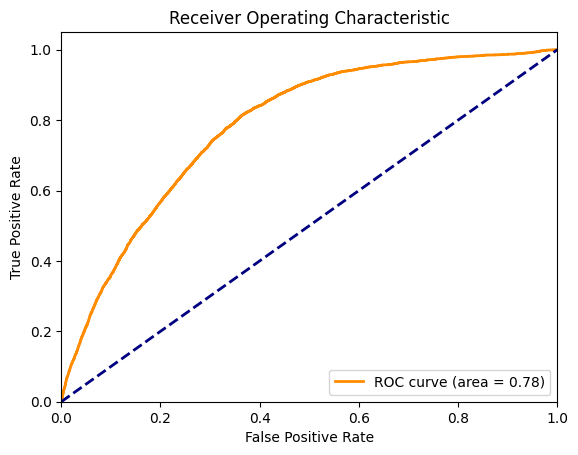

In [63]:
# Define el pipeline con el escalador y Naive Bayes
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

# Define los hiperparámetros a probar para Naive Bayes (no hay hiperparámetros para ajustar en este caso)
parameters_nb = {}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, scoring='recall', verbose=1)
grid_search_nb.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para Naive Bayes:")
print(grid_search_nb.best_params_)
print("Mejor puntuación para Naive Bayes:")
print(grid_search_nb.best_score_)

# Entrena el modelo con los mejores parámetros encontrados
best_nb_model = grid_search_nb.best_estimator_
best_nb_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_nb = best_nb_model.predict(X_test)

# Calcular métricas de rendimiento
report_nb = classification_report(y_test, y_pred_nb)
print("Informe de clasificación para Naive Bayes:")
print(report_nb)

# Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb)

# Mostrar la matriz de confusión
disp_nb.plot()
plt.show()

# Calcular y mostrar el área bajo la curva ROC
y_pred_proba_nb = best_nb_model.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_proba_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_proba_nb)

plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### K-Nearest Neighbors

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros para K-Nearest Neighbors:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Mejor puntuación para K-Nearest Neighbors:
0.11895482773597192
Informe de clasificación para K-Nearest Neighbors:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     56774
         1.0       0.26      0.12      0.17      4997

    accuracy                           0.90     61771
   macro avg       0.59      0.55      0.56     61771
weighted avg       0.87      0.90      0.88     61771



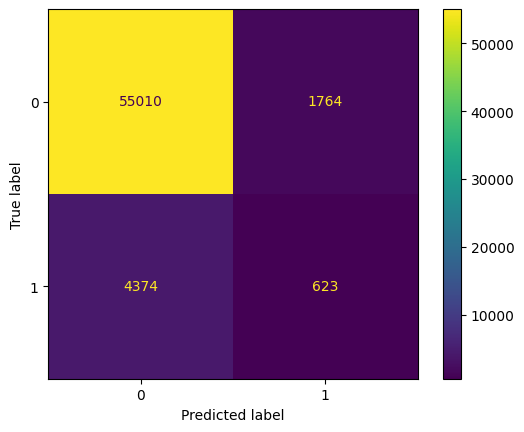

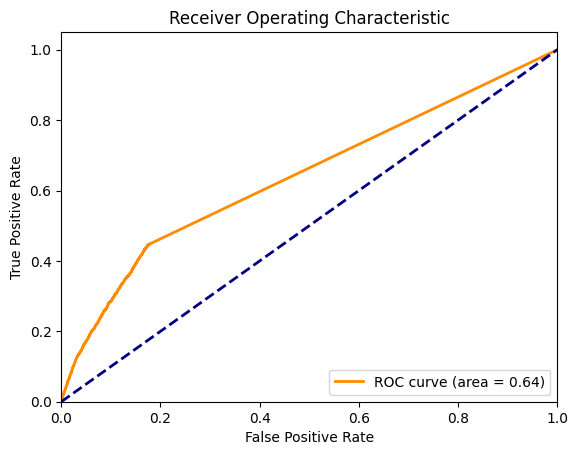

In [64]:
# Define el pipeline con el escalador y K-Nearest Neighbors
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define los hiperparámetros a probar para K-Nearest Neighbors
parameters_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_knn = GridSearchCV(pipeline_knn, parameters_knn, cv=5, scoring='recall', verbose=1)
grid_search_knn.fit(X_train, y_train)

# Imprime los mejores parámetros y la mejor puntuación
print("Mejores parámetros para K-Nearest Neighbors:")
print(grid_search_knn.best_params_)
print("Mejor puntuación para K-Nearest Neighbors:")
print(grid_search_knn.best_score_)

# Entrena el modelo con los mejores parámetros encontrados
best_knn_model = grid_search_knn.best_estimator_
best_knn_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_knn = best_knn_model.predict(X_test)

# Calcular métricas de rendimiento
report_knn = classification_report(y_test, y_pred_knn)
print("Informe de clasificación para K-Nearest Neighbors:")
print(report_knn)

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)

# Mostrar la matriz de confusión
disp_knn.plot()
plt.show()

# Calcular y mostrar el área bajo la curva ROC
y_pred_proba_knn = best_knn_model.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()